In [25]:
import jax.numpy as jnp
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

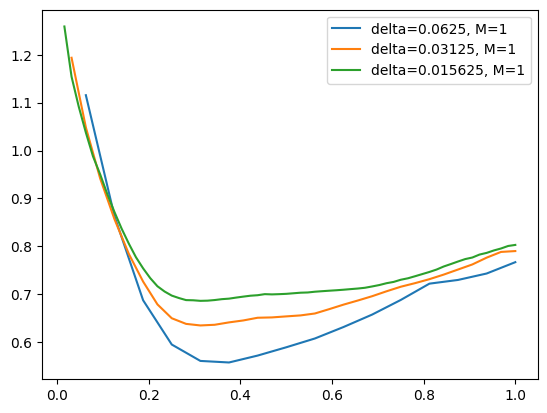

In [43]:
Ns = jnp.array([16, 32,64])
deltas = jnp.array([0.0625, 0.03125, 0.015625])
fineDeltas = Ns ** 1
Mdeltas = jnp.ones((len(deltas),)) * Ns ** 0
Ndeltas = Ns

folder = "./"
solver_name = "ekf0"
problem_name = "test"

prefix = f"{solver_name}_{problem_name}"
for n in range(len(Ndeltas)):
    delta = deltas[n]
    N = int(Ndeltas[n])
    M = int(Mdeltas[n])
    fine = int(fineDeltas[n])
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}_{M}.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}_{fine}.npy')
    N = int(N)
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, 1, N)
    ranged = range(N)
    plt.plot(ts, jnp.log(jnp.mean(jnp.linalg.norm(paths_1 - paths_2, axis=-1), axis=0)) / jnp.log(delta),
             label=f'delta={delta}, M={M}')
plt.legend()

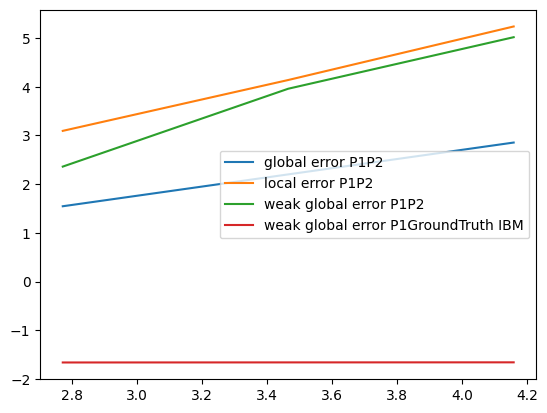

In [44]:
STRONG_GLOBAL_ERRORS_P1P2 = []
STRONG_LOCAL_ERRORS_P1P2 = []
WEAK_GLOBAL_ERRORS_P1P2 = []
WEAK_GLOBAL_ERRORS_P1GroundTruth = []
@partial(jnp.vectorize, signature="(d,x)->(d,d)")
def WEAK_POLYNOMIAL(x):
    return x @ x.T


COV_HYPOELLIPTIC_COMPONENT_ERRORS = []
for n in range(len(deltas)):
    N = int(Ndeltas[n])
    M = int(Mdeltas[n])
    fine = int(fineDeltas[n])
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}_{M}.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}_{fine}.npy')
    #paths = jnp.load(f'{folder}/{prefix}_paths_{N}_{fine}.npy')
    STRONG_GLOBAL_ERROR_P1P2 = jnp.max(jnp.mean(jnp.linalg.norm(paths_2 - paths_1, axis=-1), axis=0), axis=-1)
    STRONG_LOCAL_ERROR_P1P2 = jnp.mean(jnp.linalg.norm(paths_2[:, 1] - paths_1[:, 1], axis=-1), axis=0)
    
    MOMENT_P1 = WEAK_POLYNOMIAL(paths_1[...,jnp.newaxis])
    MOMENT_P2 = WEAK_POLYNOMIAL(paths_2[...,jnp.newaxis])
    
    WEAK_GLOBAL_ERROR_P1P2 = jnp.max(jnp.linalg.norm(jnp.linalg.norm(jnp.mean(MOMENT_P2, axis=0)-jnp.mean(MOMENT_P1, axis=0),axis=-1),axis=-1),axis=-1)
    STRONG_GLOBAL_ERRORS_P1P2.append(STRONG_GLOBAL_ERROR_P1P2)
    STRONG_LOCAL_ERRORS_P1P2.append(STRONG_LOCAL_ERROR_P1P2)
    WEAK_GLOBAL_ERRORS_P1P2.append(WEAK_GLOBAL_ERROR_P1P2)
    
    #ONLY FOR IBM
    WEAK_GLOBAL_ERROR_P1GroundTruth = jnp.linalg.norm(jnp.linalg.norm(jnp.mean(MOMENT_P1[:,-1,:], axis=0)-jnp.array([[4+1/3, 2+1/2],                                                            [2+1/2, 1+1]]),axis=-1),axis=-1)
    WEAK_GLOBAL_ERRORS_P1GroundTruth.append(WEAK_GLOBAL_ERROR_P1GroundTruth)
STRONG_GLOBAL_ERRORS_P1P2 = jnp.array(STRONG_GLOBAL_ERRORS_P1P2)
STRONG_LOCAL_ERRORS_P1P2 = jnp.array(STRONG_LOCAL_ERRORS_P1P2)
WEAK_GLOBAL_ERRORS_P1P2 = jnp.array(WEAK_GLOBAL_ERRORS_P1P2)
WEAK_GLOBAL_ERRORS_P1GroundTruth = jnp.array(WEAK_GLOBAL_ERRORS_P1GroundTruth)
plt.plot(-jnp.log(deltas), -jnp.log(STRONG_GLOBAL_ERRORS_P1P2), label='global error P1P2')
plt.plot(-jnp.log(deltas), -jnp.log(STRONG_LOCAL_ERRORS_P1P2), label='local error P1P2')
plt.plot(-jnp.log(deltas), -jnp.log(WEAK_GLOBAL_ERRORS_P1P2), label='weak global error P1P2')
plt.plot(-jnp.log(deltas), -jnp.log(WEAK_GLOBAL_ERRORS_P1GroundTruth), label='weak global error P1GroundTruth IBM')
plt.legend()

In [45]:
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(STRONG_GLOBAL_ERRORS_P1P2))
print(linear_regressor.coef_)
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(STRONG_LOCAL_ERRORS_P1P2))
print(linear_regressor.coef_)
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(WEAK_GLOBAL_ERRORS_P1P2))
print(linear_regressor.coef_)
linear_regressor = LinearRegression().fit(-jnp.log(deltas)[:-4].reshape(-1, 1), -jnp.log(WEAK_GLOBAL_ERRORS_P1GroundTruth[:-4]))
print(linear_regressor.coef_)


[0.94353217]
[1.5461223]
[1.9167075]


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

In [11]:
jnp.save(f'{prefix}_STRONG_GLOBAL_ERRORS', jnp.array([deltas, STRONG_GLOBAL_ERRORS_P1P2]))
jnp.save(f'{prefix}_STRONG_LOCAL_ERRORS', jnp.array([deltas, STRONG_LOCAL_ERRORS_P1P2]))
jnp.save(f'{prefix}_WEAK_GLOBAL_ERRORS', jnp.array([deltas, WEAK_GLOBAL_ERRORS_P1P2]))
#jnp.save(f'{prefix}_WEAK_GLOBAL_ERRORS_P1GroundTruth', jnp.array([deltas, WEAK_GLOBAL_ERRORS_P1GroundTruth]))

In [28]:
jnp.mean(MOMENT_P1, axis=0)[-1]

Array([[1.4212973]], dtype=float32)

In [62]:
STRONG_GLOBAL_ERRORS = jnp.load(f'{prefix}_STRONG_GLOBAL_ERRORS.npy')
STRONG_LOCAL_ERRORS = jnp.load(f'{prefix}_STRONG_LOCAL_ERRORS.npy')
WEAK_GLOBAL_ERRORS = jnp.load(f'{prefix}_WEAK_GLOBAL_ERRORS.npy')
#WEAK_GLOBAL_ERRORS_P1GroundTruth = jnp.load(f'{prefix}_WEAK_GLOBAL_ERRORS_P1GroundTruth.npy')

np.savetxt(f'{prefix}_STRONG_GLOBAL_ERRORS.csv', STRONG_GLOBAL_ERRORS.T, delimiter=',', header='deltas,errors', comments="")
np.savetxt(f'{prefix}_STRONG_LOCAL_ERRORS.csv', STRONG_LOCAL_ERRORS.T, delimiter=',', header='deltas,errors', comments="")
np.savetxt(f'{prefix}_WEAK_GLOBAL_ERRORS.csv', WEAK_GLOBAL_ERRORS.T, delimiter=',', header='deltas,errors', comments="")
#np.savetxt(f'{prefix}_WEAK_GLOBAL_ERRORS_P1GroundTruth.csv', WEAK_GLOBAL_ERRORS_P1GroundTruth.T, delimiter=',', header='deltas,errors', comments="")

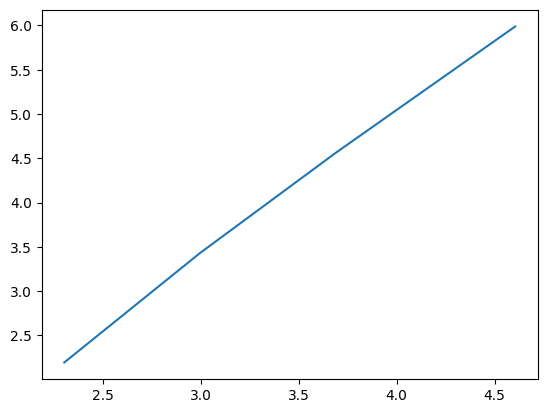

In [13]:
deltas = [0.1, 0.05, 0.025, 0.01]
LOCAL_ERRORS = []
for delta in deltas:
    experiment_local = jnp.load(f'./experiment_{delta}.npy')
    LOCAL_ERRORS.append(jnp.mean(jnp.linalg.norm(experiment_local[0] - experiment_local[1], axis=-1), axis=0))
LOCAL_ERRORS = jnp.array(LOCAL_ERRORS)
deltas = jnp.array(deltas)
plt.plot(-jnp.log(deltas), -jnp.log(LOCAL_ERRORS))

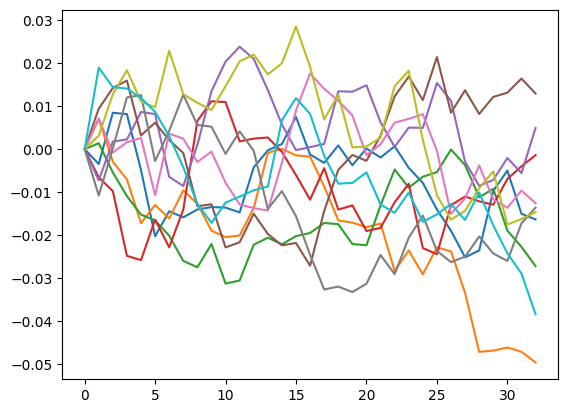

In [34]:
for k in range(10):
    plt.plot(paths_1[k]-paths_2[k])

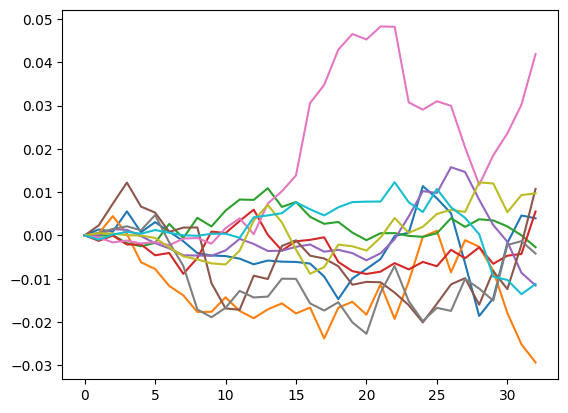

In [43]:
for k in range(10):
    plt.plot(paths_2[k]-paths_1[k])

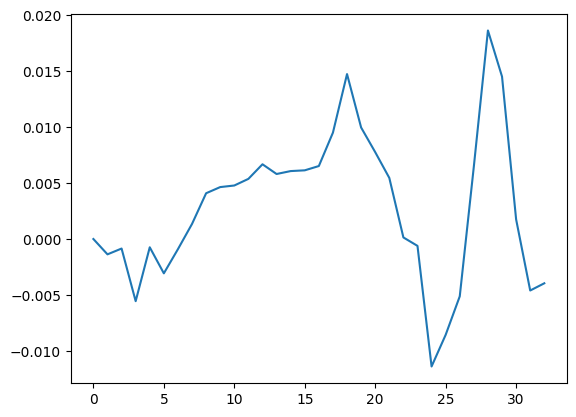

In [41]:
plt.plot(paths_1[0]-paths_2[0])

In [23]:
np.mean(jnp.linalg.norm(paths_1[:,1]-paths_2[:,1], axis=-1))

Array(0.00045015, dtype=float32)

In [18]:
jnp.sqrt(6)

Array(0.015625, dtype=float32)

In [8]:
paths_2

Array([[[ 0.00000000e+00,  0.00000000e+00],
        [ 1.12586931e-04,  1.45515741e-03],
        [ 4.97080851e-03, -8.08595940e-02],
        ...,
        [-1.18961585e+00,  6.08877301e-01],
        [-1.20378816e+00,  5.93976200e-01],
        [-1.21066630e+00,  5.89230537e-01]],

       [[ 0.00000000e+00,  0.00000000e+00],
        [-4.09867847e-03,  2.57777050e-02],
        [-1.64162964e-02,  7.97630847e-02],
        ...,
        [-9.07274663e-01, -1.99072629e-01],
        [-8.97281945e-01, -2.30285376e-01],
        [-8.92395318e-01, -2.46495470e-01]],

       [[ 0.00000000e+00,  0.00000000e+00],
        [-2.33531697e-03,  2.45059971e-02],
        [-7.45584350e-03,  2.73153689e-02],
        ...,
        [-9.63300645e-01, -4.19400111e-02],
        [-9.64934468e-01, -9.32594985e-02],
        [-9.58460331e-01, -1.50753304e-01]],

       ...,

       [[ 0.00000000e+00,  0.00000000e+00],
        [ 3.08905938e-03, -1.27637135e-02],
        [ 1.64991734e-03,  1.62610747e-02],
        ...,
     

In [9]:
paths_1

Array([[[ 0.0000000e+00,  0.0000000e+00],
        [-3.6069803e-04,  1.4058157e-03],
        [ 7.9557113e-03, -8.0496810e-02],
        ...,
        [           nan,            nan],
        [           nan,            nan],
        [           nan,            nan]],

       [[ 0.0000000e+00,  0.0000000e+00],
        [-6.9377187e-05,  2.6196990e-02],
        [-6.0673007e-03,  8.0970325e-02],
        ...,
        [           nan,            nan],
        [           nan,            nan],
        [           nan,            nan]],

       [[ 0.0000000e+00,  0.0000000e+00],
        [-1.7161743e-03,  2.4571642e-02],
        [-5.9619793e-03,  2.7488079e-02],
        ...,
        [           nan,            nan],
        [           nan,            nan],
        [           nan,            nan]],

       ...,

       [[ 0.0000000e+00,  0.0000000e+00],
        [-1.0799762e-03, -1.3197036e-02],
        [ 4.3185480e-04,  1.6162170e-02],
        ...,
        [           nan,            nan],
     

In [12]:
paths_1[0]-paths_2[0]

Array([[ 0.0000000e+00,  0.0000000e+00],
       [-4.7328498e-04, -4.9341703e-05],
       [ 2.9849028e-03,  3.6278367e-04],
       [ 5.9613585e-03,  4.1753873e-03],
       [-4.1612212e-02,  3.8248032e-01],
       [-5.6976157e-01,  3.7841098e+00],
       [-6.3587910e-01, -8.9615709e-01],
       [-1.4835653e+00,  6.9261994e+00],
       [ 1.6852367e+00, -2.6106787e+01],
       [-3.5826542e+00,  2.1158894e+02],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [        

In [13]:
paths_1[0]

Array([[ 0.0000000e+00,  0.0000000e+00],
       [-3.6069803e-04,  1.4058157e-03],
       [ 7.9557113e-03, -8.0496810e-02],
       [ 2.3498921e-02, -7.0834346e-02],
       [-1.1999083e-02,  3.3049831e-01],
       [-5.2736646e-01,  3.7278421e+00],
       [-5.7996392e-01, -8.9559895e-01],
       [-1.4174104e+00,  6.8774290e+00],
       [ 1.7708303e+00, -2.6142530e+01],
       [-3.4751790e+00,  2.1153090e+02],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       [        

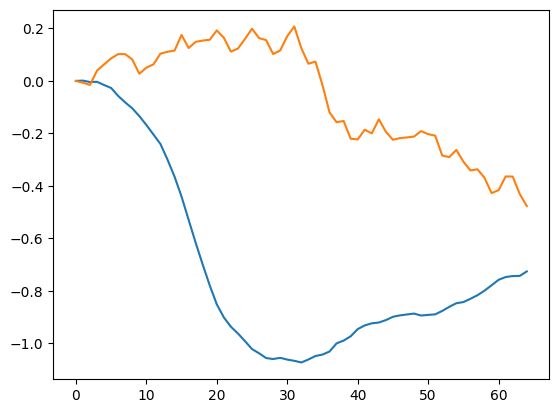

In [40]:
plt.plot(paths_1[0])

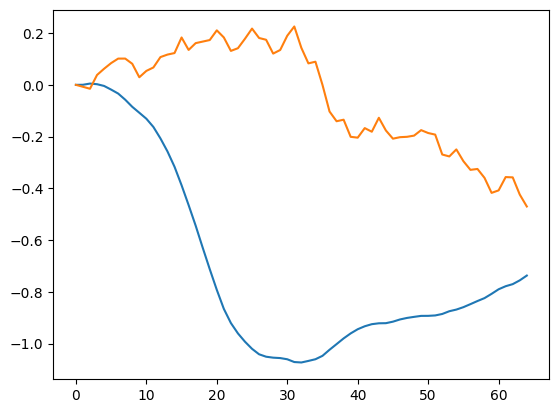

In [39]:
plt.plot(paths_2[0])